In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pulp

In [2]:
curve = [
    "Apr'21", 2.921,
    "May'21", 2.892,
    "Jun'21", 2.922,
    "Jul'21", 2.96,
    "Aug'21", 2.974,
    "Sep'21", 2.966,
    "Oct'21", 3.007,
    "Nov'21", 3.07,
    "Dec'21", 3.203,
    "Jan'22", 3.294,
    "Feb'22", 3.216,
    "Mar'22", 3.03,
    "Apr'22", 2.568,
    "May'22", 2.48,
    "Jun'22", 2.525,
    "Jul'22", 2.562,
    "Aug'22", 2.57,
    "Sep'22", 2.559,
    "Oct'22", 2.592,
    "Nov'22", 2.681,
    "Dec'22", 2.87,
    "Jan'23", 2.987,
    "Feb'23", 2.939,
    "Mar'23", 2.779,
    "Apr'23", 2.388
]

In [3]:
df = pd.DataFrame( data={ 'Contract': curve[0::2], 'Price': curve[1::2]})

/home/marcino/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Contract'>

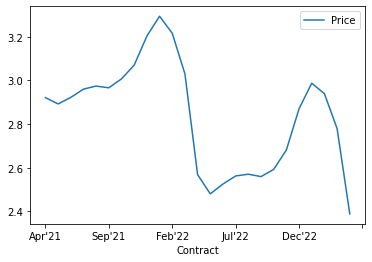

In [4]:
df.plot(x='Contract', y='Price')

In [19]:
N=12 # number of months to use
max_storage_capacity=100000
max_daily_injection=pd.DataFrame(data=[(0.0,2000),(0.5,1000),(1.0,1000)], columns=['ratchet', 'mdiq'] )
max_daily_withdrawal=pd.DataFrame( data=[(0.0,2000),(0.5,2000),(1.0,4000)], columns=['ratchet', 'mdwq'] )

<AxesSubplot:xlabel='ratchet'>

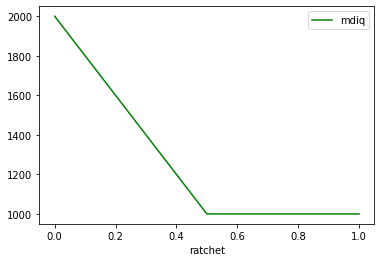

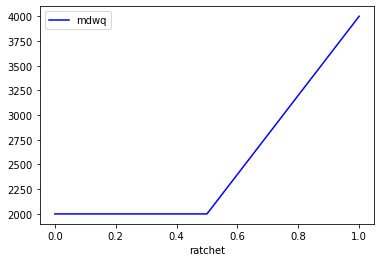

In [20]:
max_daily_injection.plot(x='ratchet',y='mdiq', style='g-', )
max_daily_withdrawal.plot(x='ratchet',y='mdwq',style='b-')

In [21]:
# injection / withdrawal quantities
I=[None]*N
W=[None]*N
for i in range(N):
    I[i] = pulp.LpVariable(f'I_{i}', lowBound=0, cat='Integer')
    W[i] = pulp.LpVariable(f'W_{i}', lowBound=0, cat='Integer')

In [22]:
# number of days in each injection / drawing month
days = list( map( lambda x: ((x+pd.DateOffset(months=1))-x).days, df.Contract.apply( lambda x: pd.to_datetime( '1-' + x ))))
#days[0] = 2
#days[1] = 2
#days[2] = 2

# number of calendar days in the simulation
K = sum( days[0:N])

prices = list(df.Price)

In [23]:
injection_charges=[None]*N
total_injection=[None]*N
daily_injection=[None]*K

# for each injection month
for i in range(N):
    total_injection[i] = I[i]*10000
    injection_charges[i] = -total_injection[i] * prices[i]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_injection[lb:ub] = [ total_injection[i] / days[i] ] * days[i]

withdrawal_credit=[None]*N
total_draw=[None]*N
daily_draw=[None]*K

# for each drawing month
for j in range(N):
    total_draw[j] = W[j]*10000
    withdrawal_credit[j] = total_draw[j] * prices[j]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_draw[lb:ub]  = [ total_draw[i] / days[i] ] * days[i]

daily_storage=[None]*K
for i in range(K):
    if i == 0:
        daily_storage[i] = daily_injection[i] - daily_draw[i]
    else:
        daily_storage[i] = daily_injection[i] - daily_draw[i] + daily_storage[i-1]

In [24]:
# ratchet range control variables 
irc = [[None] * 2 for _ in range(K-1)]
wrc = [[None] * 2 for _ in range(K-1)]

for i in range(0,K-1):
    for j in range(max_daily_injection.shape[0]-1):
        irc[i][j] = pulp.LpVariable(f'ic_{i+1}_{j}', cat='Binary')

    for j in range(max_daily_withdrawal.shape[0]-1):
        wrc[i][j] = pulp.LpVariable(f'wc_{i+1}_{j}', cat='Binary')

In [32]:
m = pulp.LpProblem("WithRatchetsDaily", pulp.LpMaximize)

# target function
m += pulp.lpSum(withdrawal_credit) + pulp.lpSum(injection_charges)

# add constraints
for i in range(K):
    m += daily_storage[i] >= 0
    m += daily_storage[i] <= max_storage_capacity

# storage is empty on day 0
m += daily_injection[0] <= max_daily_injection.loc[0, 'mdiq']
m += daily_draw[0] <= max_daily_withdrawal.loc[ 0, 'mdwq']

M1 = -200 # lower boundary for the ratchet range
M2 = 200  # higher boundary for the ratchet range

# ratchet control
for i in range(K-1):

    # injection
    # only one range is allowed
    m += pulp.lpSum( irc[i] ) == 1

    # first range
    m += irc[i][0] * max_daily_injection.loc[0,'ratchet'] + (1 - irc[i][0] ) * M1 \
         <=  daily_storage[i] / max_storage_capacity
    m += irc[i][0] * max_daily_injection.loc[1,'ratchet'] + (1 - irc[1][0] ) * M2 \
         >=  daily_storage[i] / max_storage_capacity

    # second range
    m += irc[i][1] * max_daily_injection.loc[1,'ratchet'] + (1 - irc[i][1] ) * M1 \
         <=  daily_storage[i] / max_storage_capacity
    m += irc[i][1] * max_daily_injection.loc[2,'ratchet'] + (1 - irc[1][1] ) * M2 \
         >=  daily_storage[i] / max_storage_capacity
    
    # daily rate constraint
    m += daily_injection[i+1] <= irc[i][0] * max_daily_injection.loc[1,'mdiq'] + \
         irc[i][1] * max_daily_injection.loc[2,'mdiq']
    
    # withdrawal
    # only one range is allowed
    m += pulp.lpSum( wrc[i] ) == 1

    # first range
    m += wrc[i][0] * max_daily_withdrawal.loc[0,'ratchet'] + ( 1 - wrc[i][0] ) * M1 \
         <=  daily_storage[i] / max_storage_capacity
    m += wrc[i][0] * max_daily_withdrawal.loc[1,'ratchet'] + ( 1 - wrc[i][0]) * M2 \
         >= daily_storage[i] / max_storage_capacity

    # second range
    m += wrc[i][1] * max_daily_withdrawal.loc[1,'ratchet'] + ( 1 - wrc[i][1] ) * M1 \
         <=  daily_storage[i] / max_storage_capacity
    m += wrc[i][1] * max_daily_withdrawal.loc[2,'ratchet'] + ( 1 - wrc[i][1]) * M2 \
         >= daily_storage[i] / max_storage_capacity
    
    # daily rate constraint
    m += daily_draw[i+1] <= wrc[i][0] * max_daily_withdrawal.loc[1,'mdwq'] + \
         wrc[i][1] * max_daily_withdrawal.loc[2,'mdwq']

#    m += daily_injection[i+1] <= max_daily_injection.loc[0, 'mdiq']
#    m += daily_draw[i+1] <= max_daily_withdrawal.loc[ 0, 'mdwq']


# ensure that storage on last day is empty
m += daily_storage[K-1] == 0

In [33]:
solver = pulp.getSolver('PULP_CBC_CMD')
m.solve(solver)
pulp.LpStatus[m.status]

'Optimal'

In [34]:
print( pulp.value(m.objective) )

19759.999999999985


In [35]:
for variable in m.variables():
    if variable.varValue != 0.0:
        print( "{} = {}".format(variable.name, variable.varValue) )

I_0 = 2.0
I_1 = 3.0
I_2 = 3.0
I_5 = 3.0
W_2 = 3.0
W_4 = 3.0
W_9 = 5.0
ic_100_0 = 1.0
ic_101_0 = 1.0
ic_102_0 = 1.0
ic_103_0 = 1.0
ic_104_0 = 1.0
ic_105_0 = 1.0
ic_106_0 = 1.0
ic_107_0 = 1.0
ic_108_0 = 1.0
ic_109_0 = 1.0
ic_10_0 = 1.0
ic_110_0 = 1.0
ic_111_0 = 1.0
ic_112_0 = 1.0
ic_113_0 = 1.0
ic_114_0 = 1.0
ic_115_0 = 1.0
ic_116_0 = 1.0
ic_117_0 = 1.0
ic_118_0 = 1.0
ic_119_0 = 1.0
ic_11_0 = 1.0
ic_120_0 = 1.0
ic_121_0 = 1.0
ic_122_0 = 1.0
ic_123_0 = 1.0
ic_124_0 = 1.0
ic_125_0 = 1.0
ic_126_0 = 1.0
ic_127_0 = 1.0
ic_128_0 = 1.0
ic_129_0 = 1.0
ic_12_0 = 1.0
ic_130_0 = 1.0
ic_131_0 = 1.0
ic_132_0 = 1.0
ic_133_0 = 1.0
ic_134_0 = 1.0
ic_135_0 = 1.0
ic_136_0 = 1.0
ic_137_0 = 1.0
ic_138_0 = 1.0
ic_139_0 = 1.0
ic_13_0 = 1.0
ic_140_0 = 1.0
ic_141_0 = 1.0
ic_142_0 = 1.0
ic_143_0 = 1.0
ic_144_0 = 1.0
ic_145_0 = 1.0
ic_146_0 = 1.0
ic_147_0 = 1.0
ic_148_0 = 1.0
ic_149_0 = 1.0
ic_14_0 = 1.0
ic_150_0 = 1.0
ic_151_0 = 1.0
ic_152_0 = 1.0
ic_153_0 = 1.0
ic_154_0 = 1.0
ic_155_0 = 1.0
ic_156_0 = 1.0
ic_15

In [36]:
df_result = pd.DataFrame( data={
    'gas_in_storage': map(lambda x: pulp.value(x) / max_storage_capacity, daily_storage),
    'daily_injection': map(lambda x: pulp.value(x), daily_injection),
    'daily_draw': map(lambda x: pulp.value(x), daily_draw),
})


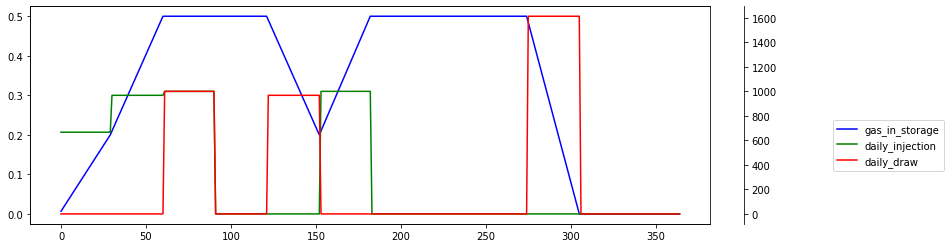

In [37]:
fig, ax = plt.subplots()
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=1.7)

df_result['gas_in_storage'].plot(ax=ax, style='b-')
df_result['daily_injection'].plot(ax=ax3, style='g-')
df_result['daily_draw'].plot(ax=ax3, style='r-')

ax3.legend([ax.get_lines()[0], ax3.get_lines()[0], ax3.get_lines()[1]], ['gas_in_storage','daily_injection', 'daily_draw'], bbox_to_anchor=(1.35, 0.5))

In [38]:
list(map(lambda x: pulp.value(x) / max_storage_capacity, daily_storage))

[0.006666666666666666,
 0.013333333333333332,
 0.02,
 0.026666666666666665,
 0.03333333333333333,
 0.039999999999999994,
 0.04666666666666666,
 0.05333333333333333,
 0.06,
 0.06666666666666667,
 0.07333333333333333,
 0.08000000000000002,
 0.08666666666666668,
 0.09333333333333334,
 0.1,
 0.10666666666666666,
 0.11333333333333333,
 0.11999999999999998,
 0.12666666666666665,
 0.1333333333333333,
 0.13999999999999996,
 0.1466666666666666,
 0.1533333333333333,
 0.15999999999999995,
 0.1666666666666666,
 0.17333333333333328,
 0.17999999999999997,
 0.18666666666666665,
 0.19333333333333333,
 0.2,
 0.20967741935483872,
 0.21935483870967742,
 0.22903225806451613,
 0.23870967741935484,
 0.24838709677419357,
 0.25806451612903225,
 0.267741935483871,
 0.2774193548387097,
 0.2870967741935484,
 0.2967741935483871,
 0.3064516129032258,
 0.3161290322580645,
 0.3258064516129032,
 0.33548387096774196,
 0.3451612903225806,
 0.3548387096774194,
 0.3645161290322581,
 0.37419354838709684,
 0.38387096774193